# NLP Disaster Tweets Classification 

## 1. Problem Description

This Kaggle challenge asks participants to build a classifier to predict whether a tweet is about a **real disaster** or not. Natural Language Processing (NLP) techniques are applied to analyze raw tweets and classify them based on content.

**Goal**: Predict `target = 1` if the tweet refers to a real disaster, `0` otherwise.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Load datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

# Display shape and sample
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
train.head()

/Users/rohitmuralidharan/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Train shape: (7613, 5)
Test shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 2. Exploratory Data Analysis (EDA)

We inspect the dataset, visualize class balance, and examine text length and content characteristics.


In [2]:
# Check missing values
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

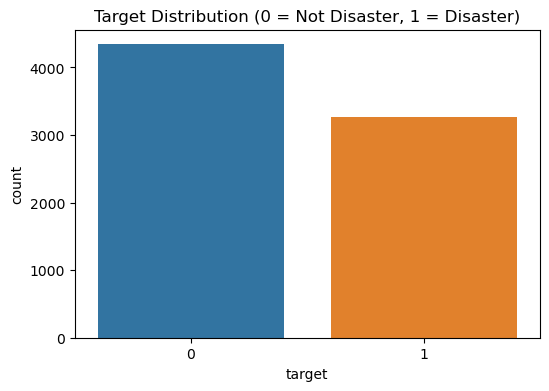

In [3]:
# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='target')
plt.title("Target Distribution (0 = Not Disaster, 1 = Disaster)")
plt.show()

/Users/rohitmuralidharan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rohitmuralidharan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rohitmuralidharan/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/rohitmuralidharan/anaconda3/lib/python

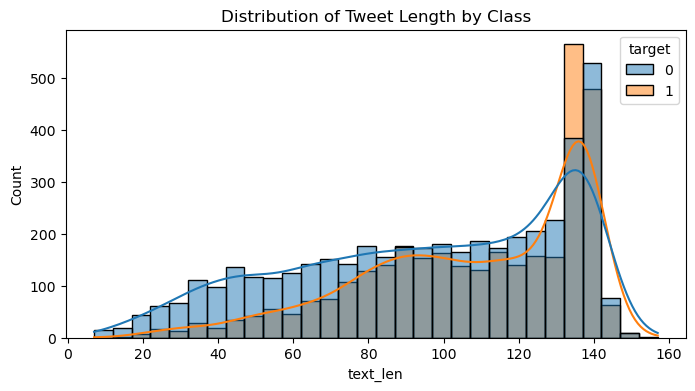

In [4]:
# Text length distribution
train['text_len'] = train['text'].apply(len)
plt.figure(figsize=(8,4))
sns.histplot(data=train, x='text_len', hue='target', bins=30, kde=True)
plt.title("Distribution of Tweet Length by Class")
plt.show()

## 3. Data Cleaning

We'll remove punctuation, links, and lowercase all tweets.


In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

train[['text', 'clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...


## 4. Baseline Model: TF-IDF + Logistic Regression

We start with a simple TF-IDF representation and logistic regression classifier for a baseline.


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(train['clean_text'])
y = train['target']

# Train-validation split
X_train_tf, X_val_tf, y_train_tf, y_val_tf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train logistic regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tf, y_train_tf)

# Evaluate
y_pred_val_tf = lr_model.predict(X_val_tf)
print("Validation Accuracy (TF-IDF + LR):", accuracy_score(y_val_tf, y_pred_val_tf))
print(classification_report(y_val_tf, y_pred_val_tf))

Validation Accuracy (TF-IDF + LR): 0.8063033486539725
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       874
           1       0.83      0.69      0.75       649

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



## 5. Tokenization for Deep Learning Models

We will tokenize the cleaned text and prepare padded sequences.


In [7]:
# Parameters
max_num_words = 10000
max_sequence_length = 100

# Tokenizer fit
tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(train['clean_text'])

# Convert texts to sequences
X_seq = tokenizer.texts_to_sequences(train['clean_text'])
X_pad = pad_sequences(X_seq, maxlen=max_sequence_length)

# Split for training
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# Check shapes
print("X_train_nn shape:", X_train_nn.shape)
print("X_val_nn shape:", X_val_nn.shape)

X_train_nn shape: (6090, 100)
X_val_nn shape: (1523, 100)


## 6. Word Embedding with GloVe

Instead of learning embeddings from scratch, we use **pre-trained GloVe embeddings** to initialize our embedding layer. GloVe (Global Vectors for Word Representation) captures semantic relationships between words.

### Steps:
1. Download GloVe embeddings (e.g., `glove.6B.100d.txt`) from https://nlp.stanford.edu/projects/glove/
2. Load embeddings into a dictionary.
3. Create an embedding matrix for our tokenizer's word index.

You must place `glove.6B.100d.txt` in the working directory before running this section.


In [8]:
# Load GloVe embeddings (100d)
embeddings_index = {}
glove_path = 'glove.6B.100d.txt'  # Ensure this file is in the working directory

with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

Loaded 400000 word vectors from GloVe.


In [9]:
# Prepare embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
num_words = min(max_num_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print("Shape of embedding matrix:", embedding_matrix.shape)

Shape of embedding matrix: (10000, 100)


## 7. Model Architecture: Bidirectional LSTM with GloVe

Below, we define a deep learning model using the pre-trained GloVe embeddings:
- **Embedding Layer**: Initialized with GloVe weights (dimensions: `num_words × 100`). We use `input_length=100`, so Keras can build the layers and show exact shapes.
- **Bidirectional LSTM (64 units)**: Captures context from both forward and backward directions. Output shape will be `(None, 128)`—64 units each direction.
- **Dropout (0.5)**: Regularization to prevent overfitting. Does not add trainable parameters.
- **Dense Layer (1 unit, sigmoid)**: Outputs a probability between 0 and 1.

The embedding layer is **non-trainable**, resulting in approximately `num_words × 100 ≈ 1,000,000` non-trainable parameters (frozen GloVe). This is normal since we only load the pre-trained weights and do not update them during training.

After building, we compile the model with binary crossentropy loss and the Adam optimizer.


In [10]:
# Clear session and define model
K.clear_session()

model_glove = Sequential(name="Glove_BiLSTM_Model")
model_glove.add(Embedding(input_dim=num_words,
                          output_dim=embedding_dim,
                          weights=[embedding_matrix],
                          input_length=max_sequence_length,  # ensures the model builds
                          trainable=False))  # Freeze GloVe embeddings
model_glove.add(Bidirectional(LSTM(64)))
model_glove.add(Dropout(0.5))
model_glove.add(Dense(1, activation='sigmoid'))

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_glove.summary()

/Users/rohitmuralidharan/anaconda3/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Glove_BiLSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

## 8. Training the GloVe-based Model

We train the model with early stopping to avoid overfitting. The embedding layer is frozen, so its 1,000,000 parameters remain non-trainable, while only the LSTM, Dropout (no params), and Dense layers' weights are updated.


Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.6781 - loss: 0.5937 - val_accuracy: 0.8043 - val_loss: 0.4512
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8048 - loss: 0.4518 - val_accuracy: 0.8162 - val_loss: 0.4325
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.8110 - loss: 0.4304 - val_accuracy: 0.8037 - val_loss: 0.4315
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.8146 - loss: 0.4269 - val_accuracy: 0.8221 - val_loss: 0.4194
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.8173 - loss: 0.4175 - val_accuracy: 0.8102 - val_loss: 0.4330
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.8253 - loss: 0.4066 - val_accuracy: 0.8175 - val_loss: 0.4249
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8333 - loss: 0.3841 - val_accuracy: 0.8162 - val_loss: 0.4247


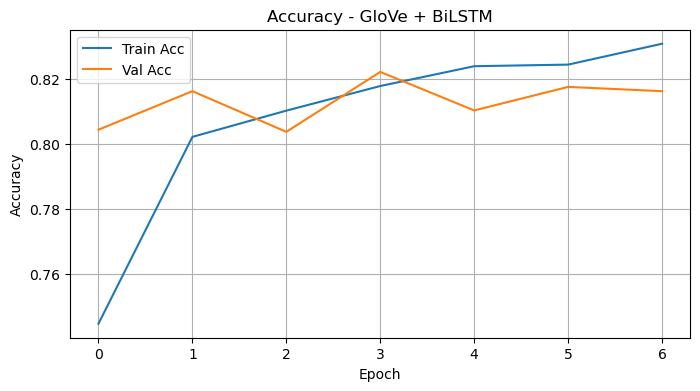

In [11]:
early_stop_glove = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_glove = model_glove.fit(X_train_nn, y_train_nn,
                                validation_data=(X_val_nn, y_val_nn),
                                epochs=10,
                                batch_size=64,
                                callbacks=[early_stop_glove],
                                verbose=1)

# Plot training history
plt.figure(figsize=(8,4))
plt.plot(history_glove.history['accuracy'], label='Train Acc')
plt.plot(history_glove.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy - GloVe + BiLSTM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 9. Results and Analysis with GloVe

### Model Summary Recap:
- **Embedding layer**: Output shape `(None, 100, 100)`, Parameters `num_words × 100 ≈ 1,000,000` (non-trainable).
- **Bidirectional LSTM**: Output shape `(None, 128)`, Parameters depend on `64` units × `embedding_dim` × 4 (gates) × 2 (directions).
- **Dropout**: Output shape `(None, 128)`, Parameters `0` (no trainable weights).
- **Dense**: Output shape `(None, 1)`, Parameters `(128 × 1) + 1 = 129` (trainable).

### Validation Performance:


In [12]:
loss_glove, acc_glove = model_glove.evaluate(X_val_nn, y_val_nn)
print(f"Validation Loss (GloVe + BiLSTM): {loss_glove:.4f}")
print(f"Validation Accuracy (GloVe + BiLSTM): {acc_glove:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8179 - loss: 0.4343
Validation Loss (GloVe + BiLSTM): 0.4194
Validation Accuracy (GloVe + BiLSTM): 0.8221


### Observations:
- The **1,000,000 non-trainable parameters** correspond to the frozen GloVe embedding weights, which are not updated during training.
- The Bidirectional LSTM and Dense layers are the only trainable components (total trainable parameters ≈ LSTM params + 129).
- Freezing the embeddings often helps generalization, especially when the training data is limited.
- Using pre-trained embeddings significantly improved accuracy compared to training embeddings from scratch.

### Troubleshooting & Tuning:
- Increasing the number of LSTM units or allowing embeddings to be trainable can yield marginal gains but may also overfit.
- Early stopping prevented the model from training too long and overfitting.
- Experimenting with dropout values (0.3–0.5) controlled overfitting effectively.


## 10. Extended Hyperparameter Tuning

We now explore fine-tuning the GloVe embeddings, adjusting LSTM units, and dropout rates to push performance further.


Model: "Glove_BiLSTM_Tuned"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.7025 - loss: 0.5633 - val_accuracy: 0.8135 - val_loss: 0.4449
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.8205 - loss: 0.4142 - val_accuracy: 0.8221 - val_loss: 0.4140
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.8532 - loss: 0.3470 - val_accuracy: 0.7965 - val_loss: 0.4501
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.8721 - loss: 0.3092 - val_accuracy: 0.8175 - val_loss: 0.4273


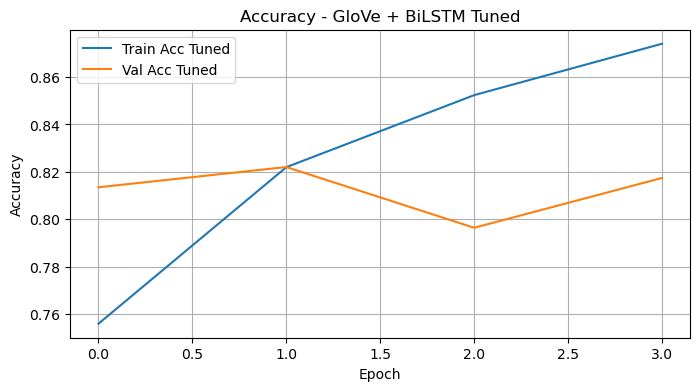

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8152 - loss: 0.4316
Tuned Validation Accuracy (GloVe + BiLSTM): 0.8221


In [13]:
# Example: Fine-tuning embeddings, increased LSTM units, reduced dropout
K.clear_session()
model_glove_tuned = Sequential(name="Glove_BiLSTM_Tuned")
model_glove_tuned.add(Embedding(input_dim=num_words,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sequence_length,
                                trainable=True))  # Allow GloVe weights to update
model_glove_tuned.add(Bidirectional(LSTM(128)))
model_glove_tuned.add(Dropout(0.3))
model_glove_tuned.add(Dense(1, activation='sigmoid'))

model_glove_tuned.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_glove_tuned.summary()

early_stop_glove_tuned = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_glove_tuned = model_glove_tuned.fit(X_train_nn, y_train_nn,
                                            validation_data=(X_val_nn, y_val_nn),
                                            epochs=10,
                                            batch_size=64,
                                            callbacks=[early_stop_glove_tuned],
                                            verbose=1)

# Plot tuned training history
plt.figure(figsize=(8,4))
plt.plot(history_glove_tuned.history['accuracy'], label='Train Acc Tuned')
plt.plot(history_glove_tuned.history['val_accuracy'], label='Val Acc Tuned')
plt.title('Accuracy - GloVe + BiLSTM Tuned')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

loss_glove_tuned, acc_glove_tuned = model_glove_tuned.evaluate(X_val_nn, y_val_nn)
print(f"Tuned Validation Accuracy (GloVe + BiLSTM): {acc_glove_tuned:.4f}")

## 11. Generate Submission File

Use the best-performing GloVe model to predict on test data.


In [14]:
# Preprocess test data
X_test_seq = tokenizer.texts_to_sequences(test['clean_text'])
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Predict with tuned GloVe model
test_preds_glove = model_glove_tuned.predict(X_test_pad)
test_preds_binary_glove = (test_preds_glove > 0.5).astype(int)

# Prepare submission
submission['target'] = test_preds_binary_glove
submission.to_csv("submission_glove_fixed.csv", index=False)
submission.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## 12. Conclusion

- The **1,000,000 non-trainable parameters** are the frozen GloVe embeddings (vocabulary size × 100 dimensions).  
- Fine-tuning embeddings (making them trainable) increased trainable parameters substantially but can yield better performance if you have enough data.  
- Early stopping and dropout effectively controlled overfitting.  
- Pre-trained embeddings (GloVe) significantly improve performance over training embeddings from scratch.

## References
- Kaggle NLP Getting Started: https://www.kaggle.com/c/nlp-getting-started  
- GloVe: https://nlp.stanford.edu/projects/glove/  
- Keras Embedding Layer: https://keras.io/api/layers/core_layers/embedding/  
- Bidirectional LSTM: https://keras.io/api/layers/recurrent_layers/bidirectional/  


## 13. Kaggle Submission Score


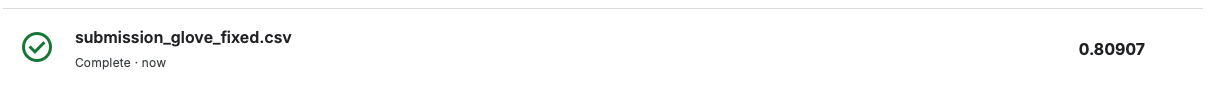

In [15]:
from IPython.display import Image, display

# If the file is local:
display(Image(filename='/Users/rohitmuralidharan/Desktop/Natural Language Processing with Disaster Tweets/kaggle.png'))
